# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
import torch


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(
    family=pv.BicopFamily.joe,
    parameters=np.array([[2.5]]), rotation=90
    )


#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.clayton,
#    parameters=np.array([[2.0]]), rotation=0
#    )

#rho_t =0.7
#nu_t = 4.0
#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.student,
#    parameters=np.array([[rho_t],
#                          [nu_t]]),
#    rotation=0
#)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_351393/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_351393/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_351393/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-27 18:04:33,183] A new study created in RDB with name: no-name-43f63a37-2ef8-4b9d-846a-914b0b03d368
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:618: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ


current_loss: 

  0%|          | 3/2000 [00:00<05:56,  5.61it/s]

tensor(1.4439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4548707008361816
current_loss: tensor(1.4393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4500356912612915
current_loss: tensor(1.4331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.424535870552063
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:18,  7.73it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4311078786849976
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4249634742736816
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:04,  8.15it/s]

current_loss_val:  1.424954891204834
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4249558448791504
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<05:26,  6.10it/s]


current_loss: tensor(1.4032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.425025463104248
Early Stop at iteration 7 with minimal loss tensor(1.4245, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3833, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<09:55,  3.36it/s]

current_loss_val:  1.3992515802383423
current_loss: tensor(1.3833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3602, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<09:10,  3.63it/s]

current_loss_val:  1.3721845149993896
current_loss: tensor(1.3602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3284, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<10:24,  3.20it/s]

current_loss_val:  1.3061448335647583
current_loss: tensor(1.3284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3260, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<12:49,  2.60it/s]

current_loss: tensor(1.3149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3013198375701904
current_loss: tensor(1.3149, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:02<15:37,  2.13it/s]

current_loss: tensor(1.3105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3001526594161987
current_loss: tensor(1.3105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3031, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:02<14:22,  2.31it/s]

current_loss_val:  1.2975335121154785
current_loss: tensor(1.3031, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<13:47,  2.41it/s]

current_loss: tensor(1.3001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2940603494644165


  0%|          | 8/2000 [00:03<12:26,  2.67it/s]

current_loss: tensor(1.3001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2926026582717896
current_loss: tensor(1.2975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2946, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:03<11:56,  2.78it/s]

current_loss_val:  1.290561318397522
current_loss: tensor(1.2946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2900, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:03<11:21,  2.92it/s]

current_loss_val:  1.284462332725525
current_loss: tensor(1.2900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2863, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:04<11:01,  3.01it/s]

current_loss_val:  1.2812480926513672
current_loss: tensor(1.2863, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:04<11:06,  2.98it/s]

current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.278296947479248
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:04<12:05,  2.74it/s]

current_loss_val:  1.2740854024887085
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:05<11:40,  2.84it/s]

current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717922925949097
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:05<11:26,  2.89it/s]

current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700679302215576
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:05<11:38,  2.84it/s]

current_loss_val:  1.2691292762756348
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:06<12:16,  2.69it/s]

current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679470777511597
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:06<10:05,  3.27it/s]

current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679507732391357
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:06<08:43,  3.78it/s]

current_loss_val:  1.268005132675171
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:06<08:41,  3.80it/s]

current_loss_val:  1.2680712938308716
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:07<07:48,  4.22it/s]

current_loss_val:  1.26754629611969
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2675046920776367
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:07<05:48,  5.68it/s]

current_loss_val:  1.2675899267196655
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674487829208374
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:07<05:16,  6.25it/s]

current_loss_val:  1.2671204805374146
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2671055793762207
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:07<03:50,  8.54it/s]

current_loss_val:  1.2671005725860596
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2669947147369385
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659112215042114


  2%|▏         | 31/2000 [00:08<03:36,  9.11it/s]

current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265451431274414
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2651197910308838
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:08<03:39,  8.96it/s]

current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264392614364624
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263904094696045
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:08<03:28,  9.40it/s]

current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629518508911133
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610760927200317
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:08<03:24,  9.59it/s]

current_loss_val:  1.2598122358322144
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593204975128174
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255309820175171


  2%|▏         | 39/2000 [00:09<03:19,  9.85it/s]

current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532652616500854
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2525922060012817
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:09<03:16,  9.96it/s]

current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523058652877808
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521454095840454
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:09<03:12, 10.16it/s]

current_loss_val:  1.2522578239440918
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252200961112976
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252091407775879


  2%|▏         | 47/2000 [00:09<03:11, 10.21it/s]

current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519973516464233
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518175840377808
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:09<03:11, 10.21it/s]

current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517881393432617
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251766562461853
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:10<03:10, 10.22it/s]

current_loss_val:  1.2517539262771606
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518141269683838
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519526481628418


  3%|▎         | 53/2000 [00:10<03:10, 10.25it/s]

current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519500255584717
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519333362579346
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:10<06:31,  4.98it/s]

current_loss_val:  1.2518131732940674
Early Stop at iteration 54 with minimal loss tensor(1.2518, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-27 18:04:51,222] Trial 0 finished with value: -2.5035083293914795 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.218553616655089, 'penalty_decorrelation_ridge_second_difference': 27.362239551543247}. Best is trial 0 with value: -2.5035083293914795.
  0%|          | 1/2000 [00:00<06:54,  4.82it/s]

current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520660161972046
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<10:07,  3.29it/s]

current_loss_val:  1.2523345947265625
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<10:27,  3.18it/s]

current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532440423965454
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<11:14,  2.96it/s]

current_loss_val:  1.2540422677993774
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<12:06,  2.75it/s]

current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2547061443328857
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:02<14:24,  2.31it/s]

current_loss_val:  1.2547961473464966
Early Stop at iteration 5 with minimal loss tensor(1.2521, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-27 18:04:54,502] Trial 1 finished with value: -2.50413179397583 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.319479424219967, 'penalty_decorrelation_ridge_second_difference': 14.344146442580227}. Best is trial 0 with value: -2.5035083293914795.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<14:15,  2.34it/s]

current_loss_val:  1.25176203250885
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<11:44,  2.83it/s]

current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251336693763733
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515308856964111
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<05:48,  5.73it/s]

current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515302896499634
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511451244354248
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:35,  7.24it/s]

current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511886358261108
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251220703125
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:18,  7.70it/s]

current_loss_val:  1.2509751319885254
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512143850326538
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:50,  8.63it/s]

current_loss_val:  1.2510696649551392
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509372234344482
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:06,  8.07it/s]

current_loss_val:  1.2506123781204224
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250780701637268
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<03:43,  8.86it/s]

current_loss_val:  1.2508316040039062
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504278421401978
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506111860275269


  1%|          | 17/2000 [00:02<03:32,  9.34it/s]

current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507270574569702
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507596015930176
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:37,  9.11it/s]

current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505676746368408
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500169277191162
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:28,  9.49it/s]

current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499382495880127
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492201328277588
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<03:52,  8.51it/s]

current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494046688079834
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493548393249512
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<03:53,  8.45it/s]

current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487280368804932
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<03:59,  8.24it/s]

current_loss_val:  1.248910665512085
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489073276519775
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487261295318604


  1%|▏         | 29/2000 [00:03<03:39,  8.99it/s]

current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2483717203140259
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:57,  8.30it/s]

current_loss_val:  1.2479729652404785
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477766275405884
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<03:57,  8.29it/s]

current_loss_val:  1.2474002838134766
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466470003128052
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:04<03:37,  9.05it/s]

current_loss_val:  1.2465972900390625
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460566759109497
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:04<03:32,  9.23it/s]

current_loss_val:  1.2463635206222534
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2462941408157349
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458096742630005


  2%|▏         | 39/2000 [00:04<03:28,  9.39it/s]

current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457517385482788
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:05<03:27,  9.43it/s]

current_loss_val:  1.2455064058303833
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457510232925415
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460212707519531


  2%|▏         | 44/2000 [00:05<03:20,  9.74it/s]

current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245957851409912
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466217279434204
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:05<04:02,  8.06it/s]


current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246239423751831
Early Stop at iteration 44 with minimal loss tensor(1.2455, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-27 18:05:00,684] Trial 2 finished with value: -2.4910128116607666 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.057752245817863, 'penalty_decorrelation_ridge_second_difference': 1.2881737480380033}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 2/2000 [00:00<03:16, 10.16it/s]

current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2522398233413696
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254288673400879
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:42,  8.96it/s]

current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565754652023315
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566334009170532


  0%|          | 5/2000 [00:00<04:15,  7.81it/s]

current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573580741882324
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25938880443573
Early Stop at iteration 5 with minimal loss tensor(1.2522, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-27 18:05:01,927] Trial 3 finished with value: -2.504479169845581 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.70475226090014, 'penalty_decorrelation_ridge_second_difference': 6.537686015978533}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 2/2000 [00:00<03:25,  9.72it/s]

current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252017855644226
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520686388015747


  0%|          | 3/2000 [00:00<03:23,  9.82it/s]

current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521990537643433
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2525626420974731
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:01,  8.27it/s]

current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2531782388687134
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539390325546265
Early Stop at iteration 5 with minimal loss tensor(1.2520, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-27 18:05:03,389] Trial 4 finished with value: -2.504035711288452 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.803091971333993, 'penalty_decorrelation_ridge_second_difference': 18.371873134550096}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 1/2000 [00:00<03:23,  9.81it/s]

current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516453266143799
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:50,  8.67it/s]

current_loss_val:  1.250836968421936
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2508502006530762
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:54,  8.51it/s]

current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505496740341187
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496200799942017
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:37,  9.18it/s]

current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498559951782227
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2497273683547974
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:01,  8.23it/s]

current_loss_val:  1.249753713607788
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500054836273193
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249938726425171
Early Stop at iteration 9 with minimal loss tensor(1.2496, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-27 18:05:05,181] Trial 5 finished with value: -2.499239921569824 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.0572576806651135, 'penalty_decorrelation_ridge_second_difference': 0.5934590671409217}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 2/2000 [00:00<03:19, 10.03it/s]

current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2522207498550415
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256745457649231
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:16, 10.16it/s]

current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593220472335815
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2574377059936523
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:56,  8.42it/s]


current_loss_val:  1.2568001747131348
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560511827468872
Early Stop at iteration 5 with minimal loss tensor(1.2522, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-27 18:05:06,399] Trial 6 finished with value: -2.504441261291504 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.53494965797939, 'penalty_decorrelation_ridge_second_difference': 0.37914636641888977}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 2/2000 [00:00<03:22,  9.86it/s]

current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2522869110107422
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2533074617385864


  0%|          | 3/2000 [00:00<03:23,  9.83it/s]

current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255789875984192
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567585706710815
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:01,  8.27it/s]

current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573912143707275
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2579411268234253
Early Stop at iteration 5 with minimal loss tensor(1.2523, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-27 18:05:07,651] Trial 7 finished with value: -2.5045742988586426 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.607434582278323, 'penalty_decorrelation_ridge_second_difference': 13.291622888961893}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 1/2000 [00:00<03:23,  9.84it/s]

current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518901824951172
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518855333328247
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:20,  9.94it/s]

current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519549131393433
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521945238113403
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:23,  9.79it/s]

current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2522149085998535
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2526426315307617
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:55,  8.46it/s]


current_loss_val:  1.2524290084838867
Early Stop at iteration 6 with minimal loss tensor(1.2519, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-27 18:05:09,037] Trial 8 finished with value: -2.5037710666656494 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.266971227104136, 'penalty_decorrelation_ridge_second_difference': 15.245486569246472}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 1/2000 [00:00<04:33,  7.32it/s]

current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517070770263672
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:01,  8.27it/s]

current_loss_val:  1.2511471509933472
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512201070785522
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511889934539795


  0%|          | 5/2000 [00:00<03:55,  8.47it/s]

current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507609128952026
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:39,  9.09it/s]

current_loss_val:  1.2507290840148926
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506927251815796
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250418782234192
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<05:02,  6.59it/s]

current_loss_val:  1.2505415678024292
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503395080566406
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:32,  7.30it/s]

current_loss_val:  1.2499300241470337
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2495434284210205
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:04,  8.13it/s]

current_loss_val:  1.249530553817749
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2495596408843994
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<03:44,  8.85it/s]

current_loss_val:  1.2492334842681885
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2495415210723877
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494715452194214


  1%|          | 18/2000 [00:02<03:33,  9.28it/s]

current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492153644561768
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493537664413452
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:27,  9.56it/s]

current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487261295318604
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482978105545044
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:34,  9.20it/s]

current_loss_val:  1.2479690313339233
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247062087059021
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:03<03:25,  9.61it/s]

current_loss_val:  1.2473430633544922
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474685907363892
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2476954460144043


  1%|▏         | 27/2000 [00:03<03:40,  8.96it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475244998931885
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<03:59,  8.23it/s]


current_loss_val:  1.2476588487625122
Early Stop at iteration 27 with minimal loss tensor(1.2471, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-27 18:05:12,932] Trial 9 finished with value: -2.494123935699463 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.955781694959218, 'penalty_decorrelation_ridge_second_difference': 1.9924377438381782}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 2/2000 [00:00<03:21,  9.92it/s]

current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523410320281982
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528916597366333
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:17, 10.09it/s]

current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544747591018677
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256815791130066
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:57,  8.39it/s]


current_loss_val:  1.2568449974060059
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568296194076538
Early Stop at iteration 5 with minimal loss tensor(1.2523, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-27 18:05:14,142] Trial 10 finished with value: -2.5046815872192383 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.99409566206734, 'penalty_decorrelation_ridge_second_difference': 18.75527837355019}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 2/2000 [00:00<03:25,  9.70it/s]

current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520806789398193
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2527707815170288


  0%|          | 3/2000 [00:00<03:33,  9.37it/s]

current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552024126052856
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546781301498413


  0%|          | 5/2000 [00:00<04:06,  8.10it/s]

current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2547308206558228
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2547962665557861
Early Stop at iteration 5 with minimal loss tensor(1.2521, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-27 18:05:15,397] Trial 11 finished with value: -2.5041611194610596 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.974487680727208, 'penalty_decorrelation_ridge_second_difference': 9.270891706399397}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 2/2000 [00:00<03:18, 10.09it/s]

current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518796920776367
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251895785331726
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:18, 10.07it/s]

current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25247061252594
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521330118179321
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:57,  8.40it/s]

current_loss_val:  1.252261996269226
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523747682571411
Early Stop at iteration 5 with minimal loss tensor(1.2519, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-27 18:05:16,624] Trial 12 finished with value: -2.5037593841552734 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.008078672486326, 'penalty_decorrelation_ridge_second_difference': 10.494784128020665}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252447485923767
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:37,  9.18it/s]

current_loss_val:  1.2544739246368408
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2583130598068237
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584786415100098


  0%|          | 5/2000 [00:00<04:10,  7.96it/s]

current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586102485656738
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2588491439819336
Early Stop at iteration 5 with minimal loss tensor(1.2524, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-27 18:05:17,866] Trial 13 finished with value: -2.504894733428955 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.94182095871053, 'penalty_decorrelation_ridge_second_difference': 11.544492405324037}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 2/2000 [00:00<03:20,  9.97it/s]

current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521228790283203
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528307437896729
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:21,  9.89it/s]

current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549338340759277
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551530599594116
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:59,  8.33it/s]

current_loss_val:  1.2551355361938477
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553006410598755
Early Stop at iteration 5 with minimal loss tensor(1.2521, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-27 18:05:19,133] Trial 14 finished with value: -2.5042455196380615 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.988161118204427, 'penalty_decorrelation_ridge_second_difference': 10.789970533727274}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 2/2000 [00:00<03:23,  9.82it/s]

current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518738508224487
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520285844802856


  0%|          | 3/2000 [00:00<03:22,  9.85it/s]

current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2525091171264648
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2524583339691162
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:14,  7.83it/s]

current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2526307106018066
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2522008419036865
Early Stop at iteration 5 with minimal loss tensor(1.2519, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-27 18:05:20,484] Trial 15 finished with value: -2.5037474632263184 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.716812299892316, 'penalty_decorrelation_ridge_second_difference': 2.2043604896796407}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 2/2000 [00:00<03:31,  9.45it/s]

current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516975402832031
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2513278722763062
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:21,  9.92it/s]

current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515113353729248
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510673999786377
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:27,  9.60it/s]

current_loss_val:  1.2509254217147827
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250888705253601
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:25,  9.70it/s]

current_loss_val:  1.2507224082946777
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506182193756104
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500429153442383


  0%|          | 10/2000 [00:01<03:20,  9.94it/s]

current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501779794692993
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503503561019897
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:34,  9.25it/s]

current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503570318222046
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503894567489624
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:44,  8.84it/s]


current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504150867462158
Early Stop at iteration 13 with minimal loss tensor(1.2500, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-27 18:05:22,792] Trial 16 finished with value: -2.5000858306884766 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.9453822424223093, 'penalty_decorrelation_ridge_second_difference': 9.333103017500104}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 1/2000 [00:00<04:34,  7.28it/s]

current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515572309494019
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:03,  8.21it/s]

current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503693103790283
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503697872161865
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:15,  7.82it/s]

current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503552436828613
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:03,  8.19it/s]

current_loss_val:  1.2497397661209106
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250120997428894
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:32,  9.35it/s]

current_loss_val:  1.2498522996902466
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2497973442077637
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500975131988525


  0%|          | 10/2000 [00:01<03:31,  9.42it/s]

current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496892213821411
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:40,  9.01it/s]

current_loss_val:  1.2497283220291138
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494900226593018
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491148710250854


  1%|          | 14/2000 [00:01<03:29,  9.48it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487549781799316
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488664388656616
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:24,  9.69it/s]

current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490900754928589
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491081953048706
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:21,  9.81it/s]

current_loss_val:  1.2486631870269775
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489373683929443
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:18,  9.94it/s]

current_loss_val:  1.2488785982131958
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248841404914856
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:46,  8.72it/s]

current_loss_val:  1.2489166259765625
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487913370132446
Early Stop at iteration 22 with minimal loss tensor(1.2487, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-27 18:05:26,215] Trial 17 finished with value: -2.497326135635376 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7646950430434494, 'penalty_decorrelation_ridge_second_difference': 0.9040363549671488}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 2/2000 [00:00<03:18, 10.09it/s]

current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517056465148926
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516347169876099
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:17, 10.12it/s]

current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515672445297241
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514487504959106
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:34,  9.31it/s]

current_loss_val:  1.2511976957321167
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507778406143188
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:31,  9.41it/s]

current_loss_val:  1.2507097721099854
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506601810455322
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:23,  9.77it/s]

current_loss_val:  1.2503747940063477
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2502003908157349
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501548528671265


  1%|          | 12/2000 [00:01<03:23,  9.77it/s]

current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498732805252075
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493232488632202
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:19,  9.94it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492274045944214
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491534948349
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:17, 10.05it/s]

current_loss_val:  1.248518943786621
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480239868164062
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478655576705933


  1%|          | 20/2000 [00:02<03:17, 10.03it/s]

current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477890253067017
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473787069320679
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:16, 10.09it/s]

current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2471287250518799
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2471866607666016
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:28,  9.47it/s]

current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247239112854004
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473067045211792
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:31,  9.33it/s]

current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473865747451782
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473981380462646
Early Stop at iteration 25 with minimal loss tensor(1.2471, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-27 18:05:29,861] Trial 18 finished with value: -2.4942572116851807 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.1161975988975703, 'penalty_decorrelation_ridge_second_difference': 18.546855216552693}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 1/2000 [00:00<03:24,  9.79it/s]

current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519335746765137
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:47,  8.79it/s]

current_loss_val:  1.252120852470398
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2530308961868286
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:51,  8.61it/s]

current_loss_val:  1.2531813383102417
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253234624862671
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:32,  7.33it/s]


current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2537370920181274
Early Stop at iteration 5 with minimal loss tensor(1.2519, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-27 18:05:31,255] Trial 19 finished with value: -2.5038671493530273 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.147638398097445, 'penalty_decorrelation_ridge_second_difference': 0.44227815469307497}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 2/2000 [00:00<03:22,  9.86it/s]

current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517752647399902
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251421570777893


  0%|          | 4/2000 [00:00<03:19, 10.01it/s]

current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518489360809326
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251643419265747
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:22,  9.85it/s]

current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251444697380066
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251592755317688
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:59,  8.32it/s]


current_loss_val:  1.2514568567276
Early Stop at iteration 6 with minimal loss tensor(1.2514, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-27 18:05:32,737] Trial 20 finished with value: -2.502842903137207 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.498585375322685, 'penalty_decorrelation_ridge_second_difference': 5.771601751479282}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 2/2000 [00:00<03:25,  9.73it/s]

current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251683235168457
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516106367111206


  0%|          | 4/2000 [00:00<03:29,  9.53it/s]

current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515370845794678
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514047622680664


  0%|          | 6/2000 [00:00<03:25,  9.69it/s]

current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511248588562012
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250619649887085


  0%|          | 8/2000 [00:00<03:23,  9.77it/s]

current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505422830581665
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505067586898804


  0%|          | 9/2000 [00:00<03:23,  9.79it/s]

current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504183053970337
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503433227539062
current_loss: 

  1%|          | 12/2000 [00:01<03:21,  9.86it/s]

tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2502517700195312
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2502459287643433


  1%|          | 14/2000 [00:01<03:17, 10.08it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250242829322815
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250244379043579
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:21,  9.86it/s]

current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2502444982528687
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2502073049545288
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:18,  9.99it/s]

current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501851320266724
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25002920627594
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:37,  9.11it/s]

current_loss_val:  1.249543309211731
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490772008895874
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:28,  9.49it/s]

current_loss_val:  1.2488219738006592
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480624914169312
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:24,  9.67it/s]

current_loss_val:  1.2473986148834229
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472445964813232
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:35,  9.14it/s]

current_loss_val:  1.24710214138031
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246577262878418
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:27,  9.51it/s]

current_loss_val:  1.2460401058197021
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461042404174805
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460782527923584


  2%|▏         | 30/2000 [00:03<03:23,  9.66it/s]

current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245981216430664
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245869517326355
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:19,  9.86it/s]

current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245794653892517
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458014488220215
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:33,  9.21it/s]

current_loss_val:  1.2457612752914429
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457635402679443
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:28,  9.40it/s]

current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457689046859741
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457917928695679
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:04<03:28,  9.40it/s]


current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458058595657349
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458062171936035
Early Stop at iteration 38 with minimal loss tensor(1.2458, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-27 18:05:37,470] Trial 21 finished with value: -2.4915225505828857 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.1447454332973652, 'penalty_decorrelation_ridge_second_difference': 19.33136251492923}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 2/2000 [00:00<03:24,  9.75it/s]

current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25167715549469
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251615285873413


  0%|          | 4/2000 [00:00<03:28,  9.55it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515572309494019
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514458894729614


  0%|          | 6/2000 [00:00<03:28,  9.57it/s]

current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511988878250122
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504242658615112


  0%|          | 7/2000 [00:00<03:27,  9.62it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504686117172241
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504359483718872
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:29,  9.50it/s]

current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504184246063232
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250379204750061
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:24,  9.73it/s]

current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503440380096436
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250300645828247
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:36,  9.19it/s]

current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503008842468262
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250269889831543
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:33,  9.31it/s]

current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250067949295044
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250024437904358
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:25,  9.63it/s]

current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498948574066162
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494432926177979
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 20/2000 [00:02<03:25,  9.64it/s]

tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490371465682983
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482331991195679
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:20,  9.85it/s]

current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247983455657959
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477604150772095
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 24/2000 [00:02<03:22,  9.75it/s]

tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247128963470459
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465786933898926
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:34,  9.21it/s]

current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467464208602905
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467615604400635
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:25,  9.61it/s]

current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467576265335083
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467631101608276
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|▏         | 28/2000 [00:03<03:34,  9.19it/s]


tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467608451843262
Early Stop at iteration 28 with minimal loss tensor(1.2466, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-27 18:05:41,271] Trial 22 finished with value: -2.493156909942627 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6665911310966083, 'penalty_decorrelation_ridge_second_difference': 20.467264785311258}. Best is trial 2 with value: -2.4910128116607666.
  0%|          | 2/2000 [00:00<03:21,  9.92it/s]

current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516824007034302
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516334056854248
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:19, 10.02it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251590371131897
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514952421188354
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:45,  8.82it/s]

current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512701749801636
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507470846176147


  0%|          | 8/2000 [00:00<03:33,  9.34it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505650520324707
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505550384521484


  0%|          | 9/2000 [00:00<03:38,  9.11it/s]

current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250550627708435
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:44,  8.87it/s]

current_loss_val:  1.250556230545044
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505892515182495
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:31,  9.39it/s]

current_loss_val:  1.2505452632904053
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250538945198059
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504539489746094


  1%|          | 16/2000 [00:01<03:25,  9.68it/s]

current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2502650022506714
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249526858329773


  1%|          | 18/2000 [00:01<03:23,  9.75it/s]

current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493703365325928
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492868900299072


  1%|          | 20/2000 [00:02<03:22,  9.76it/s]

current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492039203643799
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491227388381958


  1%|          | 21/2000 [00:02<03:22,  9.77it/s]

current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490137815475464
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489490509033203
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:41,  8.93it/s]

current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487766742706299
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485867738723755


  1%|▏         | 25/2000 [00:02<03:56,  8.37it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2484416961669922
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:42,  8.86it/s]

current_loss_val:  1.24811589717865
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478528022766113
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:31,  9.34it/s]

current_loss_val:  1.2475537061691284
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472507953643799
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:26,  9.52it/s]

current_loss_val:  1.2466858625411987
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461365461349487
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459900379180908


  2%|▏         | 34/2000 [00:03<03:21,  9.76it/s]

current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457534074783325
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453696727752686


  2%|▏         | 35/2000 [00:03<03:21,  9.77it/s]

current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24539315700531
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245371699333191


  2%|▏         | 37/2000 [00:03<03:19,  9.82it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245234727859497
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:33,  9.20it/s]

current_loss_val:  1.244999647140503
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244920015335083
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:25,  9.51it/s]

current_loss_val:  1.2448110580444336
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244687557220459
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:23,  9.64it/s]

current_loss_val:  1.244580626487732
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445722818374634
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24455726146698


  2%|▏         | 45/2000 [00:04<03:19,  9.82it/s]

current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445265054702759
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:05<03:32,  9.19it/s]

current_loss_val:  1.2445306777954102
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445608377456665
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:05<03:38,  8.93it/s]

current_loss_val:  1.2447015047073364
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2447422742843628
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:05<03:32,  9.18it/s]


current_loss_val:  1.2447376251220703
Early Stop at iteration 49 with minimal loss tensor(1.2445, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-27 18:05:47,280] Trial 23 finished with value: -2.4890530109405518 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6077821547902562, 'penalty_decorrelation_ridge_second_difference': 21.529182109197045}. Best is trial 23 with value: -2.4890530109405518.
  0%|          | 1/2000 [00:00<05:42,  5.84it/s]

current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517424821853638
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:00,  8.32it/s]

current_loss_val:  1.251708984375
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516130208969116
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:28,  9.57it/s]

current_loss_val:  1.2513283491134644
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512083053588867
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511941194534302


  0%|          | 8/2000 [00:00<03:30,  9.46it/s]

current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511464357376099
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510764598846436


  0%|          | 10/2000 [00:01<03:35,  9.22it/s]

current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509725093841553
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509692907333374


  1%|          | 12/2000 [00:01<03:28,  9.51it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250963568687439
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509487867355347


  1%|          | 14/2000 [00:01<03:25,  9.66it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509126663208008
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250581979751587


  1%|          | 16/2000 [00:01<03:21,  9.86it/s]

current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505252361297607
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250457525253296
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:23,  9.72it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501986026763916
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500181198120117
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:20,  9.89it/s]

current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249667763710022
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494256496429443
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:23,  9.73it/s]

current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493311166763306
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2483950853347778
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:20,  9.87it/s]

current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247631549835205
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474839687347412
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:22,  9.73it/s]

current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474918365478516
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474838495254517
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:22,  9.74it/s]

current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474615573883057
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474089860916138
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:23,  9.67it/s]

current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474108934402466
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247419834136963
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:20,  9.83it/s]

current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475508451461792
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247550129890442
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:32,  9.25it/s]


current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475539445877075
Early Stop at iteration 32 with minimal loss tensor(1.2474, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-27 18:05:51,458] Trial 24 finished with value: -2.4948179721832275 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.42082752592236505, 'penalty_decorrelation_ridge_second_difference': 28.738671304062514}. Best is trial 23 with value: -2.4890530109405518.
  0%|          | 1/2000 [00:00<04:34,  7.27it/s]

current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519067525863647
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:41,  9.01it/s]

current_loss_val:  1.2520215511322021
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252357006072998
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:16,  7.77it/s]

current_loss_val:  1.2532711029052734
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532871961593628
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253281831741333
Early Stop at iteration 5 with minimal loss tensor(1.2519, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-27 18:05:52,723] Trial 25 finished with value: -2.5038135051727295 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.601361000539107, 'penalty_decorrelation_ridge_second_difference': 28.265069675425398}. Best is trial 23 with value: -2.4890530109405518.
  0%|          | 1/2000 [00:00<04:41,  7.10it/s]

current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251830816268921
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:39,  9.10it/s]

current_loss_val:  1.2518619298934937
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519444227218628
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:30,  9.48it/s]

current_loss_val:  1.2522071599960327
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521699666976929
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521438598632812
Early Stop at iteration 5 with minimal loss 

  0%|          | 5/2000 [00:00<04:18,  7.71it/s]


tensor(1.2518, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-27 18:05:54,081] Trial 26 finished with value: -2.503661632537842 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.338428602865953, 'penalty_decorrelation_ridge_second_difference': 21.681227140038953}. Best is trial 23 with value: -2.4890530109405518.
  0%|          | 2/2000 [00:00<03:35,  9.26it/s]

current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251649022102356
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2513803243637085


  0%|          | 3/2000 [00:00<03:29,  9.53it/s]

current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510981559753418
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:55,  8.47it/s]

current_loss_val:  1.2506052255630493
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505879402160645
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:37,  9.18it/s]

current_loss_val:  1.2504472732543945
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249963402748108
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501487731933594


  0%|          | 10/2000 [00:01<03:28,  9.55it/s]

current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499868869781494
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499468326568604


  1%|          | 12/2000 [00:01<03:25,  9.65it/s]

current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500439882278442
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501189708709717


  1%|          | 14/2000 [00:01<03:24,  9.73it/s]

current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501683235168457
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2502000331878662


  1%|          | 14/2000 [00:01<03:46,  8.79it/s]


current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250149130821228
Early Stop at iteration 14 with minimal loss tensor(1.2499, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-27 18:05:56,330] Trial 27 finished with value: -2.4998936653137207 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.2483914061739525, 'penalty_decorrelation_ridge_second_difference': 13.539743878219763}. Best is trial 23 with value: -2.4890530109405518.
  0%|          | 1/2000 [00:00<04:55,  6.77it/s]

current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517951726913452
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:02,  8.25it/s]

current_loss_val:  1.2517976760864258
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517991065979004
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:50,  8.67it/s]

current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518434524536133
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517998218536377
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:34,  9.28it/s]

current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517755031585693
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251670241355896
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:34,  9.29it/s]

current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516412734985352
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516465187072754
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:39,  9.06it/s]

current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251769781112671
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517552375793457


  1%|          | 12/2000 [00:01<04:35,  7.22it/s]

current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517452239990234
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517173290252686
Early Stop at iteration 12 with minimal loss tensor(1.2516, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-27 18:05:58,651] Trial 28 finished with value: -2.5032825469970703 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.078241748471102, 'penalty_decorrelation_ridge_second_difference': 22.318430098386433}. Best is trial 23 with value: -2.4890530109405518.
  0%|          | 2/2000 [00:00<03:20,  9.97it/s]

current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516838312149048
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516402006149292
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:23,  9.82it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516013383865356
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515084743499756


  0%|          | 5/2000 [00:00<03:52,  8.57it/s]

current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512823343276978
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:01,  8.24it/s]

current_loss_val:  1.2507644891738892
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250586748123169
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:46,  8.78it/s]

current_loss_val:  1.2505229711532593
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504589557647705
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:42,  8.95it/s]

current_loss_val:  1.2503970861434937
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501885890960693
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:32,  9.35it/s]

current_loss_val:  1.250104546546936
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501015663146973
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:29,  9.47it/s]

current_loss_val:  1.2501338720321655
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500334978103638
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:23,  9.75it/s]

current_loss_val:  1.250056266784668
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500513792037964
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:41,  8.96it/s]

current_loss_val:  1.2499996423721313
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499538660049438
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:30,  9.40it/s]

current_loss_val:  1.2499319314956665
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2495827674865723
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:23,  9.72it/s]

current_loss_val:  1.2493047714233398
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491804361343384
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488770484924316


  1%|▏         | 25/2000 [00:02<03:23,  9.72it/s]

current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2486584186553955
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:36,  9.10it/s]

current_loss_val:  1.2483887672424316
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481895685195923
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:27,  9.50it/s]

current_loss_val:  1.2474536895751953
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463841438293457
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:24,  9.63it/s]

current_loss_val:  1.246132254600525
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459460496902466
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456578016281128


  2%|▏         | 34/2000 [00:03<03:20,  9.81it/s]

current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455909252166748
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455015182495117


  2%|▏         | 36/2000 [00:03<03:21,  9.76it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453619241714478
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452259063720703


  2%|▏         | 37/2000 [00:03<03:39,  8.93it/s]

current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2451900243759155
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:50,  8.52it/s]

current_loss_val:  1.2451248168945312
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449885606765747
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:50,  8.49it/s]

current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449259757995605
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449284791946411
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:34,  9.14it/s]

current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449276447296143
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448830604553223
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:04<03:43,  8.73it/s]

current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448385953903198
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448264360427856
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:05<03:53,  8.35it/s]

current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2447361946105957
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446794509887695


  2%|▏         | 49/2000 [00:05<03:37,  8.98it/s]

current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446709871292114
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446638345718384


  3%|▎         | 51/2000 [00:05<03:32,  9.18it/s]

current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445940971374512
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446199655532837


  3%|▎         | 53/2000 [00:05<03:25,  9.47it/s]

current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446328401565552
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446362972259521


  3%|▎         | 54/2000 [00:05<03:35,  9.02it/s]


current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244622826576233
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446402311325073
Early Stop at iteration 54 with minimal loss tensor(1.2446, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-27 18:06:05,271] Trial 29 finished with value: -2.4891879558563232 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5284604944301476, 'penalty_decorrelation_ridge_second_difference': 22.093045485307243}. Best is trial 23 with value: -2.4890530109405518.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4393, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<00:47, 20.92it/s]

current_loss: tensor(1.4393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<00:40, 24.57it/s]

current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<00:38, 25.97it/s]

current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:00<00:37, 26.28it/s]

current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:00<00:38, 25.61it/s]

current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4025, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:00<00:37, 26.01it/s]

current_loss: tensor(1.4025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:00<00:39, 24.47it/s]

current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:01<00:39, 24.54it/s]

current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:01<00:38, 25.29it/s]

current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:01<00:38, 25.03it/s]

current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:01<00:38, 24.96it/s]

current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:01<00:40, 23.93it/s]

current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:01<00:45, 21.00it/s]

current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:02<00:44, 21.33it/s]

current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 51/1000 [00:02<00:45, 21.08it/s]

current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:02<00:41, 22.78it/s]

current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:02<00:39, 23.66it/s]

current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 66/1000 [00:02<00:38, 24.01it/s]

current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 69/1000 [00:02<00:41, 22.54it/s]

current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 72/1000 [00:03<00:39, 23.49it/s]

current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:03<01:16, 12.14it/s]

current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 77/1000 [00:03<01:41,  9.10it/s]

current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 82/1000 [00:04<01:17, 11.85it/s]

current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 88/1000 [00:04<00:53, 17.10it/s]

current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  9%|▉         | 91/1000 [00:05<01:46,  8.53it/s]

current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 93/1000 [00:05<01:52,  8.07it/s]

current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 96/1000 [00:05<01:29, 10.08it/s]

current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 99/1000 [00:05<01:12, 12.42it/s]

current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 102/1000 [00:06<01:10, 12.74it/s]

current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 104/1000 [00:07<02:46,  5.39it/s]

current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 11%|█         | 106/1000 [00:07<02:46,  5.37it/s]

current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 11%|█         | 107/1000 [00:07<01:05, 13.60it/s]

current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 107 with minimal loss tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4009, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<01:57,  8.47it/s]

current_loss: tensor(1.3682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.382000207901001
current_loss: tensor(1.3682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3053523302078247
current_loss: tensor(1.3192, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<01:56,  8.54it/s]

current_loss: tensor(1.3308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.294768214225769
current_loss: tensor(1.3045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2921020984649658
current_loss: tensor(1.2976, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<01:46,  9.34it/s]

current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.286435842514038
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2828569412231445
current_loss: tensor(1.2856, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<01:50,  8.98it/s]

current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.281139850616455
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2788530588150024
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:01<01:44,  9.50it/s]

current_loss_val:  1.2740551233291626
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2685906887054443
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648340463638306


  1%|          | 12/1000 [00:01<01:41,  9.71it/s]

current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628213167190552
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2603691816329956
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:01<01:45,  9.32it/s]

current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2599111795425415
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:01<01:44,  9.39it/s]

current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2597541809082031
current_loss: 

  2%|▏         | 16/1000 [00:01<01:44,  9.44it/s]

tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591609954833984
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:01<01:50,  8.86it/s]

current_loss_val:  1.2590850591659546
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2590352296829224
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:02<01:52,  8.71it/s]

current_loss_val:  1.2589448690414429
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259021520614624
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  2%|▏         | 21/1000 [00:02<01:46,  9.22it/s]

tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593698501586914
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2596299648284912
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:02<01:42,  9.55it/s]

current_loss_val:  1.2599818706512451
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:02<01:49,  8.93it/s]

current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2597438097000122
Early Stop at iteration 23 with minimal loss tensor(1.2589, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [ ]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [10]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}

model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                optimizer="Adam",
                lr_mu = 1e-3,
                lr_cholesky = 1e-4,
                lr_rho = 3e-4,
                lr_tau = 1.5e-3,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 30,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.5,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.001, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 10,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 150 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 150])
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  1%|          | 5/800 [00:24<59:30,  4.49s/it]  

[convergence] ELBO/obs=-6.801204  smoothed=-6.696586  tol=0.001

Iteration [5/800] train=6.8012  S_train=4 S_val=32  lr=[0.001, 0.0001, 0.0015]  σ̄=0.0542 σmin=0.0517 σmax=0.0585  β_KL=0.57
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.049399  τ₁≈1.6409  τ₂≈3.1599  |  (EB targets) τ₄*≈0.38458  τ₁*≈85.534  τ₂*≈137.1
E_qf_total≈37.2056  E_qf1≈0.3154  E_qf2≈0.2648
[monitor] τ₄·E_qf≈1.84  target≈14.31 | τ₁·E_qf1≈0.52  target≈26.98 | τ₂·E_qf2≈0.84  target≈36.30
 [ELBO] per-obs=-6.801204


  1%|▏         | 10/800 [00:40<44:54,  3.41s/it]

[convergence] ELBO/obs=-7.073309  smoothed=-6.820380  tol=0.001

Iteration [10/800] train=7.0733  S_train=4 S_val=32  lr=[0.001, 0.0001, 0.0015]  σ̄=0.0590 σmin=0.0536 σmax=0.0716  β_KL=0.65
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.031057  τ₁≈1.3181  τ₂≈2.344  |  (EB targets) τ₄*≈0.38556  τ₁*≈82.621  τ₂*≈139.13
E_qf_total≈37.0603  E_qf1≈0.3500  E_qf2≈0.2561
[monitor] τ₄·E_qf≈1.15  target≈14.29 | τ₁·E_qf1≈0.46  target≈28.92 | τ₂·E_qf2≈0.60  target≈35.62
 [ELBO] per-obs=-7.073309


  2%|▏         | 15/800 [00:56<41:57,  3.21s/it]

[convergence] ELBO/obs=-7.478847  smoothed=-7.036417  tol=0.001

Iteration [15/800] train=7.4788  S_train=4 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0633 σmin=0.0551 σmax=0.1036  β_KL=0.73
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.023423  τ₁≈1.2362  τ₂≈2.0962  |  (EB targets) τ₄*≈0.38569  τ₁*≈81.397  τ₂*≈141.16
E_qf_total≈37.0401  E_qf1≈0.3653  E_qf2≈0.2476
[monitor] τ₄·E_qf≈0.87  target≈14.29 | τ₁·E_qf1≈0.45  target≈29.74 | τ₂·E_qf2≈0.52  target≈34.95
 [ELBO] per-obs=-7.478847


  2%|▎         | 20/800 [01:12<41:17,  3.18s/it]

[convergence] ELBO/obs=-7.907808  smoothed=-7.335637  tol=0.001

Iteration [20/800] train=7.9078  S_train=4 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0660 σmin=0.0561 σmax=0.1217  β_KL=0.82
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.019937  τ₁≈1.2221  τ₂≈2.039  |  (EB targets) τ₄*≈0.38559  τ₁*≈80.873  τ₂*≈142.29
E_qf_total≈37.0548  E_qf1≈0.3720  E_qf2≈0.2430
[monitor] τ₄·E_qf≈0.74  target≈14.29 | τ₁·E_qf1≈0.45  target≈30.08 | τ₂·E_qf2≈0.50  target≈34.57
 [ELBO] per-obs=-7.907808


  3%|▎         | 25/800 [01:28<41:13,  3.19s/it]

[convergence] ELBO/obs=-8.293451  smoothed=-7.683588  tol=0.001

Iteration [25/800] train=8.2935  S_train=4 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0687 σmin=0.0570 σmax=0.1431  β_KL=0.90
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.016925  τ₁≈1.2092  τ₂≈2.0116  |  (EB targets) τ₄*≈0.38535  τ₁*≈79.986  τ₂*≈141.43
E_qf_total≈37.0914  E_qf1≈0.3835  E_qf2≈0.2465
[monitor] τ₄·E_qf≈0.63  target≈14.29 | τ₁·E_qf1≈0.46  target≈30.68 | τ₂·E_qf2≈0.50  target≈34.86
 [ELBO] per-obs=-8.293451


  4%|▍         | 30/800 [01:47<49:16,  3.84s/it]

[convergence] ELBO/obs=-8.848664  smoothed=-8.092791  tol=0.001

Iteration [30/800] train=8.8487  S_train=8 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0703 σmin=0.0575 σmax=0.1550  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.015554  τ₁≈1.2042  τ₂≈2.01  |  (EB targets) τ₄*≈0.38514  τ₁*≈80.11  τ₂*≈142.98
E_qf_total≈37.1226  E_qf1≈0.3819  E_qf2≈0.2402
[monitor] τ₄·E_qf≈0.58  target≈14.30 | τ₁·E_qf1≈0.46  target≈30.59 | τ₂·E_qf2≈0.48  target≈34.34
 [ELBO] per-obs=-8.848664


  4%|▍         | 35/800 [02:03<41:59,  3.29s/it]

[convergence] ELBO/obs=-8.891551  smoothed=-8.416644  tol=0.001

Iteration [35/800] train=8.8916  S_train=8 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0718 σmin=0.0580 σmax=0.1660  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.014107  τ₁≈1.2005  τ₂≈2.009  |  (EB targets) τ₄*≈0.38485  τ₁*≈80.041  τ₂*≈143.15
E_qf_total≈37.1655  E_qf1≈0.3828  E_qf2≈0.2395
[monitor] τ₄·E_qf≈0.52  target≈14.30 | τ₁·E_qf1≈0.46  target≈30.64 | τ₂·E_qf2≈0.48  target≈34.28
 [ELBO] per-obs=-8.891551


  5%|▌         | 40/800 [02:19<40:31,  3.20s/it]

[convergence] ELBO/obs=-8.779400  smoothed=-8.589057  tol=0.001

Iteration [40/800] train=8.7794  S_train=8 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0729 σmin=0.0583 σmax=0.1754  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.013118  τ₁≈1.1955  τ₂≈2.007  |  (EB targets) τ₄*≈0.38464  τ₁*≈79.342  τ₂*≈142.27
E_qf_total≈37.1970  E_qf1≈0.3920  E_qf2≈0.2431
[monitor] τ₄·E_qf≈0.49  target≈14.31 | τ₁·E_qf1≈0.47  target≈31.11 | τ₂·E_qf2≈0.49  target≈34.58
 [ELBO] per-obs=-8.779400


  6%|▌         | 45/800 [02:34<40:02,  3.18s/it]

[convergence] ELBO/obs=-8.753759  smoothed=-8.664905  tol=0.001

Iteration [45/800] train=8.7538  S_train=8 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0737 σmin=0.0585 σmax=0.1814  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.012331  τ₁≈1.1926  τ₂≈2.0082  |  (EB targets) τ₄*≈0.38449  τ₁*≈79.341  τ₂*≈142.82
E_qf_total≈37.2191  E_qf1≈0.3921  E_qf2≈0.2408
[monitor] τ₄·E_qf≈0.46  target≈14.31 | τ₁·E_qf1≈0.47  target≈31.11 | τ₂·E_qf2≈0.48  target≈34.39
 [ELBO] per-obs=-8.753759


  6%|▋         | 50/800 [02:50<39:51,  3.19s/it]

[convergence] ELBO/obs=-8.730781  smoothed=-8.708401  tol=0.001

Iteration [50/800] train=8.7308  S_train=8 S_val=32  lr=[6.25e-05, 1e-05, 9.375e-05]  σ̄=0.0745 σmin=0.0587 σmax=0.1872  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.011561  τ₁≈1.1918  τ₂≈2.0113  |  (EB targets) τ₄*≈0.38432  τ₁*≈79.304  τ₂*≈143.16
E_qf_total≈37.2443  E_qf1≈0.3925  E_qf2≈0.2394
[monitor] τ₄·E_qf≈0.43  target≈14.31 | τ₁·E_qf1≈0.47  target≈31.13 | τ₂·E_qf2≈0.48  target≈34.28
 [ELBO] per-obs=-8.730781


  7%|▋         | 55/800 [03:06<39:36,  3.19s/it]

[convergence] ELBO/obs=-8.734705  smoothed=-8.723802  tol=0.001

Iteration [55/800] train=8.7347  S_train=16 S_val=32  lr=[6.25e-05, 1e-05, 9.375e-05]  σ̄=0.0752 σmin=0.0589 σmax=0.1928  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.011129  τ₁≈1.1907  τ₂≈2.0124  |  (EB targets) τ₄*≈0.38422  τ₁*≈79.582  τ₂*≈143.85
E_qf_total≈37.2588  E_qf1≈0.3889  E_qf2≈0.2367
[monitor] τ₄·E_qf≈0.41  target≈14.32 | τ₁·E_qf1≈0.46  target≈30.95 | τ₂·E_qf2≈0.48  target≈34.05
 [ELBO] per-obs=-8.734705


  7%|▋         | 56/800 [03:13<42:47,  3.45s/it]

Converged (ELBO plateau) at epoch 57 with Δ<tol=0.001.


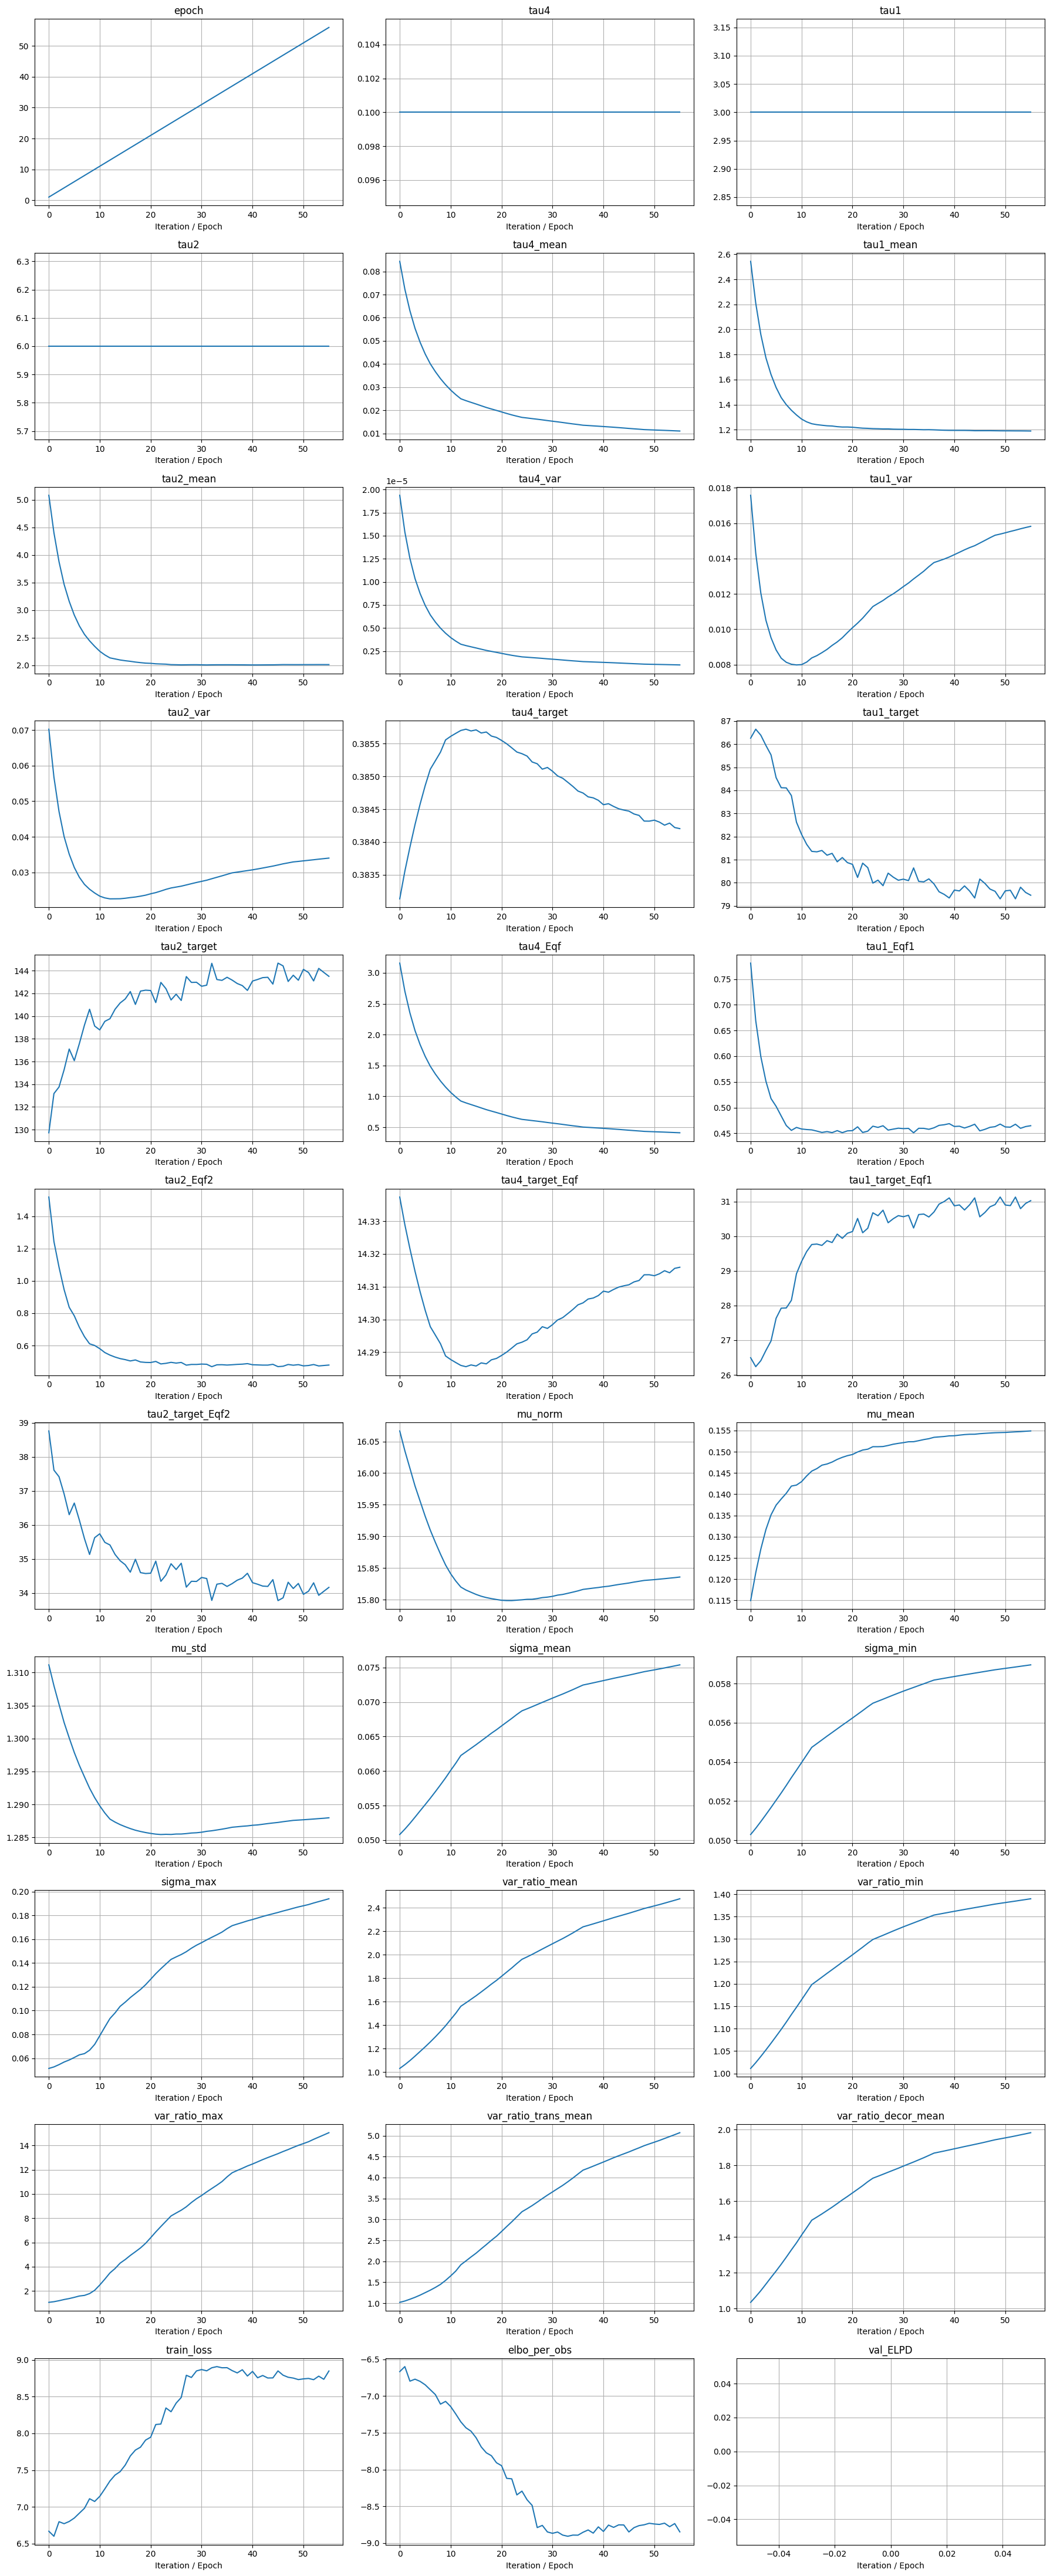

In [11]:

monitor = output["monitor"]

# Filter keys that are plottable (1D numeric sequences)
plot_keys = [k for k, v in monitor.items() if hasattr(v, "__len__") and not isinstance(v, (str, bytes))]

n = len(plot_keys)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, key in zip(axes, plot_keys):
    ax.plot(monitor[key])
    ax.set_title(key)
    ax.set_xlabel("Iteration / Epoch")
    ax.grid(True)

# Hide empty subplots (if any)
for i in range(len(plot_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [12]:
import torch

def build_full_covariance(VI) -> torch.Tensor:
    """
    Construct the full covariance matrix Σ (D x D) implied by the block-diagonal
    structure in VI_Model.

    Σ = blockdiag( Σ_block1, Σ_block2, ..., diag(σ_diag^2) )
    """
    D = VI.mu.numel()
    Sigma = torch.zeros(D, D, device=VI.mu.device)

    # Diagonal part
    if VI.num_diag > 0:
        var_diag = VI.sigma_diag ** 2  # [D_diag]
        Sigma[VI.diag_indices, VI.diag_indices] = var_diag

    # Block parts
    if VI.block_sizes:
        L_blocks = VI._build_L_blocks()
        for idx, L in zip(VI.block_indices, L_blocks):
            Sigma_block = L @ L.T   # [K, K]
            # idx is a 1D index tensor; we need outer indexing
            idx = idx.to(Sigma.device)
            Sigma[idx.unsqueeze(1), idx.unsqueeze(0)] = Sigma_block

    return Sigma



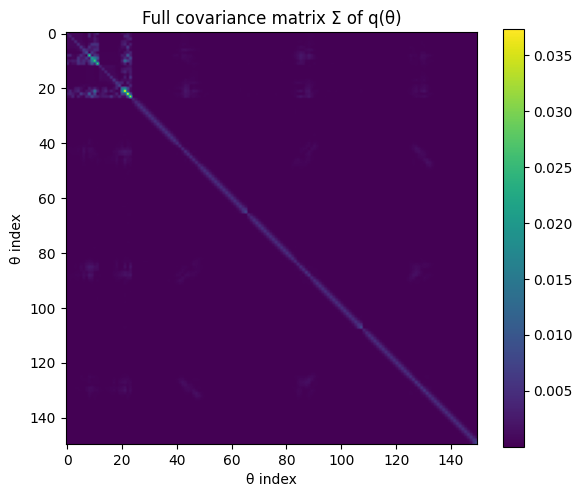

In [ ]:
import matplotlib.pyplot as plt

VI = output["vi_model"]  # from train_bayes
Sigma = build_full_covariance(VI).detach().cpu()

plt.figure(figsize=(6, 5))
plt.imshow(torch.log1p(Sigma.abs()), cmap="viridis")
plt.colorbar()
plt.title("Full covariance matrix Σ of q(θ)")
plt.xlabel("θ index")
plt.ylabel("θ index")
plt.tight_layout()
plt.show()


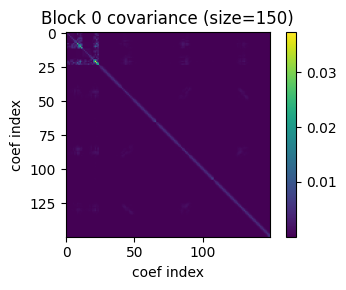

In [ ]:
def plot_blocks_covariance(VI):
    import matplotlib.pyplot as plt

    if not VI.block_sizes:
        print("No MV blocks defined in VI_Model.")
        return

    L_blocks = VI._build_L_blocks()
    for b, (idx, L) in enumerate(zip(VI.block_indices, L_blocks)):
        Sigma_b = (L @ L.T).detach().cpu()
        plt.figure(figsize=(4, 3))
        #plt.imshow(Sigma_b, interpolation="nearest")
        plt.imshow(torch.log1p(Sigma_b.abs()), cmap="viridis")
        plt.colorbar()
        plt.title(f"Block {b} covariance (size={idx.numel()})")
        plt.xlabel("coef index")
        plt.ylabel("coef index")
        plt.tight_layout()
        plt.show()

# usage:
plot_blocks_covariance(VI)

In [15]:

VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [16]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [17]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0357
KLD GTM      Train Data:  0.0235
KLD Gaussian Train Data:  0.0945
KLD Copula   Train Data:  -0.0012

KLD BGTM      Test  Data:  0.0421
KLD GTM      Test  Data:  0.0332
KLD Gaussian Test  Data:  0.1089
KLD Copula   Test  Data:  0.0054


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [18]:
model.approximate_transformation_inverse()
#synthetic_samples = model.sample(10000)
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

synthetic_samples = VI.predictive_sample(
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    n_samples=10_000,
    S=32,
)

model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]


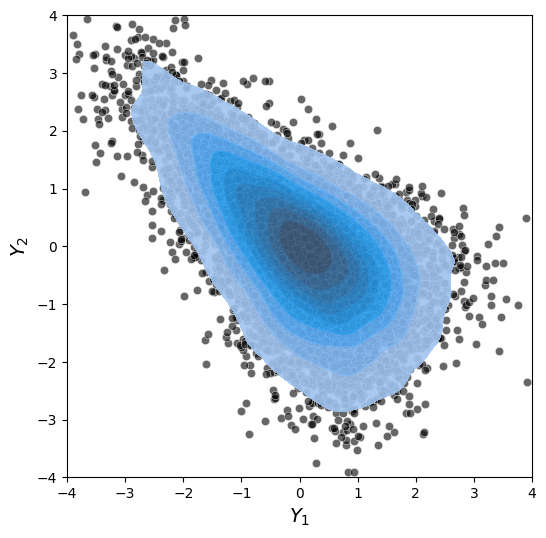

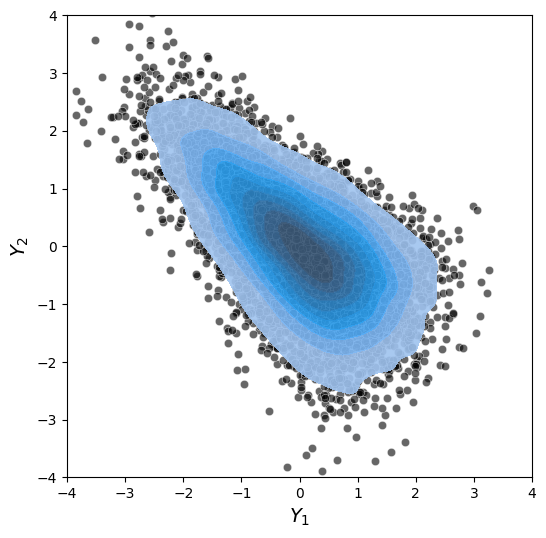

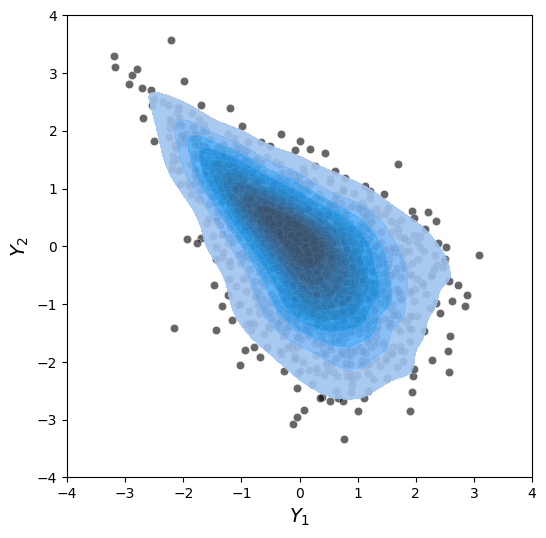

In [19]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [20]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [21]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


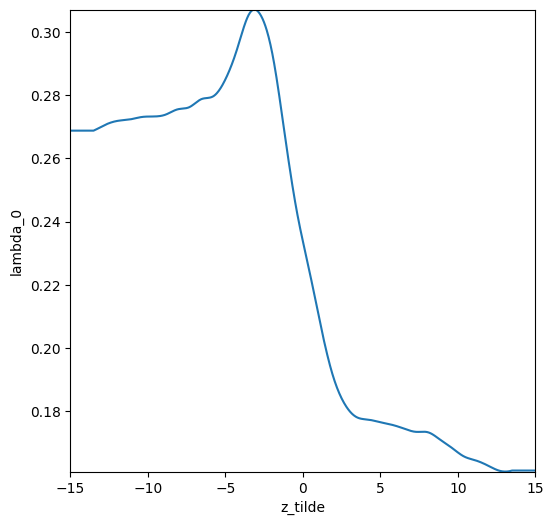

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


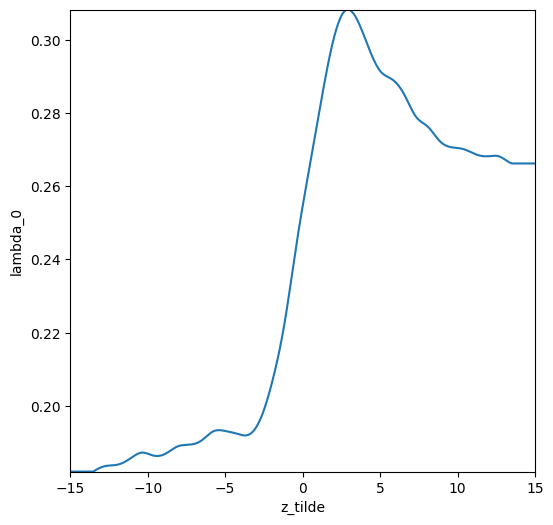

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


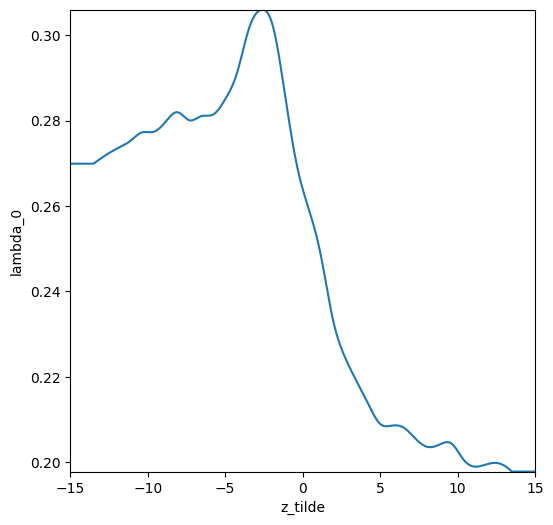

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)